Analysis.ipynb  - Interesting ways to explore the data

socialsent/ - Actual code for the package

data/:

    Outputs and Inputs (make sep folder within for outputs and inputs):

    - Make a file in folder called outputs.json 
    - Have the following file structure:
        {'body': 'your text'},
        {'body': 'your text 2'},
         

SocialSentRunning.ipynb - this script

DEFAULT SEEDS:

In [2]:
from socialsent import seeds
print(seeds.POSITIVE_TWEET)
print(seeds.NEGATIVE_TWEET)

['love', 'loved', 'loves', 'awesome', 'nice', 'amazing', 'best', 'fantastic', 'correct', 'happy']
['hate', 'hated', 'hates', 'terrible', 'nasty', 'awful', 'worst', 'horrible', 'wrong', 'sad']


# Required functions

SOCIALSENT Function

In [3]:
from socialsent.reddit import subreddit_run, subredditgen
from socialsent import constants
from argparse import ArgumentParser


def compute_polarities(subreddit,  stem=False,  positive_seeds = [], negative_seeds = [],
                       window_size=None,low_thresh=100,run=True,gen=True):
    '''
    
    subreddit - string - name of folder in /data file with outputs.json
    stem - BOOL - whether to stem or not
    positive_seeds - list - list of positive seeds
    negative_seeds - list - list of negative seeds
    window_size - int - if None, treat entire row as one
    low_thresh - int - exclude words below this threshold
    
    '''
    
    interval=None
    intervals=None

    if positive_seeds:
        seeds.POSITIVE_TWEET = positive_seeds
        seeds.NEGATIVE_TWEET = negative_seeds


    constants.set_constants(stem, interval, intervals,gender=False,low_thresh=low_thresh)
    if gen == True:
        subredditgen.main(subreddit,window_size)
    
    if run == True:
        subreddit_run.main(subreddit)

In [4]:
pos_seeds = seeds.POSITIVE_TWEET
neg_seeds = seeds.NEGATIVE_TWEET

UTILITY methods

In [5]:
def load_df(sub, prefix='', scale=True, counts=True):
    pols = pickle.load(
        open("data/{}/{}polarities.pkl".format(sub, prefix), "rb"))
    means = defaultdict(list)
    for run in pols:
        for word, value in run.items():
            means[word].append(value)

    df = pd.DataFrame([(word, np.nanmean(values), np.nanstd(values))
                       for word, values in means.items()],
                      columns=["word", "mean_sent", "std"])

    df = df.sort_values(by=["mean_sent"], ascending=False)

    if counts:
        get_top5_coocs(df, sub, prefix)

    if scale:
        scaler = StandardScaler(with_std=False)
        df["mean_sent"] = scaler.fit_transform(df["mean_sent"].values.reshape(
            -1, 1))
    df = df[df["word"].apply(lambda x: len(x)) > 1]

    return df.set_index('word')


def get_top5_coocs(df, subreddit, prefix):
    mat = sparse_io.retrieve_mat_as_coo("data/{}/{}counts.bin".format(
        subreddit, prefix).encode()).tocsr()
    index = pickle.load(
        open('data/{}/{}index.pkl'.format(subreddit, prefix), 'rb'))

    arr = np.array(mat.todense())

    rev_index = {v: k for k, v in index.items()}

    # remove words that we don't need counts for
    pol_idx = np.array([index[word] for word in df['word']])
    arr = arr[pol_idx, :]

    # remove stopwords
    stopword_idx = np.array(
        [index[stopword] for stopword in STOPWORDS if stopword in index])
    arr[:, stopword_idx] = 0

    top_idx = np.argsort(arr, axis=1)[:, -5:]

    top_words = [list(map(lambda x: rev_index[x], row)) for row in top_idx]
    df['cooccurring_words'] = top_words

In [6]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.preprocessing import StandardScaler

import json
from tqdm.notebook import tqdm

import os

# Wiki Example 

In [7]:
from vaderSentiment import vaderSentiment

In [8]:
sentiment = vaderSentiment.SentimentIntensityAnalyzer()

sortedSenti = sorted(sentiment.lexicon.items(), key=lambda x:x[1])
sentiment.lexicon['kill']
sortedSenti[:25]

[('rapist', -3.9),
 ('raping', -3.8),
 ('slavery', -3.8),
 ('fu', -3.7),
 ('kill', -3.7),
 ('murder', -3.7),
 ('rape', -3.7),
 ('terrorist', -3.7),
 ('hatefulness', -3.6),
 ('hell', -3.6),
 ('motherfucker', -3.6),
 ('murderer', -3.6),
 ('raped', -3.6),
 ('rapers', -3.6),
 ('terrorism', -3.6),
 ('fatality', -3.5),
 ('killed', -3.5),
 ('killings', -3.5),
 ('rapes', -3.5),
 ('suicidal', -3.5),
 ('suicide', -3.5),
 ('torturers', -3.5),
 ('apocalyptic', -3.4),
 ('brutalizing', -3.4),
 ('cancer', -3.4)]

In [9]:
["freedom", "glorious", "glory", "perfect", "perfectly", "paradise", "reign", "help", "recovered", "recover", "helped", "free", "freed", "liberate", "liberated", "save", "saved", "intervened", "support", "resolve", "resolved", "geurrilla", "leader", "safe", "safety"]
["enslaved", "murder", "murdered", "terror", "terrorist", "terrorism", "murderer", "brutal", "brutalizing", "dictator", "massacre", "oppressed", "loot", "looted", "pillage", "pillaged", "regime", "genocide", "horror", "horrors", "oppressor", "oppressors", "occupy", "occupation", "cruel"]
 

['enslaved',
 'murder',
 'murdered',
 'terror',
 'terrorist',
 'terrorism',
 'murderer',
 'brutal',
 'brutalizing',
 'dictator',
 'massacre',
 'oppressed',
 'loot',
 'looted',
 'pillage',
 'pillaged',
 'regime',
 'genocide',
 'horror',
 'horrors',
 'oppressor',
 'oppressors',
 'occupy',
 'occupation',
 'cruel']

Use vader sentiment list of words

look at which words occur frequently in corpus

manually select these seed words

input into socialsent

In [10]:
data = 'WikipediaTest'

In [11]:
pos_seeds = seeds.POSITIVE_HIST
neg_seeds = seeds.NEGATIVE_HIST

compute_polarities(data,positive_seeds=pos_seeds,negative_seeds=neg_seeds,window_size=50,low_thresh=25)

Getting and writing dictionary...


100%|███████████████████████████████████████████████████████████████████████| 221782/221782 [00:16<00:00, 13641.26it/s]


Generating word co-occurrences...


100%|█████████████████████████████████████████████████████████████████████████| 221782/221782 [11:06<00:00, 332.65it/s]


Generating PPMI vectors...
Generating SVD vectors...
Factorising 36383139 with shape (11430, 11430)
Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['perfectly', 'resolved', 'freedom', 'saved', 'support', 'happy', 'helped', 'reign', 'safe', 'delightful', 'recover', 'resolve', 'intervened', 'love', 'safety', 'freed', 'liberated', 'excellent', 'pleasant', 'lovely', 'liberate', 'help', 'paradise', 'glorious', 'geurrilla', 'glory', 'fortunate', 'perfect', 'free', 'good', 'recovered', 'loved', 'save', 'leader'] ['terrorist', 'pillage', 'terrorism', 'occupy', 'regime', 'oppressors', 'oppressor', 'hated', 'pillaged', 'horrors', 'looted', 'brutal', 'brutalizing', 'hate', 'occupation', 'unhappy', 'horror', 'genocide', 'oppressed', 'enslaved', 'unfortunate', 'disgusting', 'murder', 'evil', 'dictator', 'massacre', 'cruel', 'bad', 'poor', 'murderer', 'murdered', 'terror', 'unpleasant', 'loot', 'horrible']


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [25:18<00:00, 30.38s/it]


In [12]:
df = load_df(data,counts=False)

In [103]:
df

,mean_sent,std
word,,
provide,0.460782,0.122268
received,0.441430,0.164711
intervention,0.439766,0.039149
aid,0.438466,0.106754
make,0.426559,0.157213
...,...,...
atrocities,-0.408534,0.020884
looting,-0.408756,0.028035
massacres,-0.408773,0.025956


<AxesSubplot: >

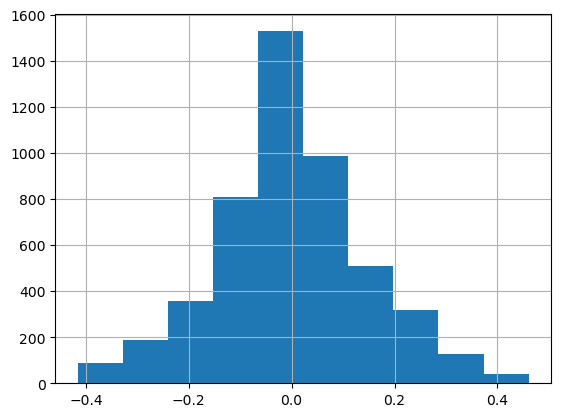

In [14]:
df.mean_sent.hist()

In [116]:
df

,mean_sent,std
word,,
provide,0.460782,0.122268
received,0.441430,0.164711
intervention,0.439766,0.039149
aid,0.438466,0.106754
make,0.426559,0.157213
provided,0.422364,0.137196
gain,0.421058,0.149868
military,0.418786,0.128577
former,0.415992,0.137590


In [16]:
with open(f'data/{data}/polarities.pkl','rb') as file:
    pols = pickle.load(file)

In [17]:
pols

[{'terrain': 0.4202159307004003,
  'coordinated': 0.2140268944348984,
  'governments': 0.5046977876924986,
  'deeply': 0.2896507065646589,
  'deliberately': 0.1478499649559633,
  'scale': 0.1442580209990578,
  'flew': 0.21279223837750055,
  'relatives': 0.20648624168406646,
  'boy': 0.3812453036179773,
  'emperor': 0.3116835078255291,
  'levels': 0.2343534593729315,
  'mexican': 0.21681913799061558,
  'lima': 0.2175519056983354,
  'siamese': 0.3879614839849392,
  'zanzibar': 0.2954977898570499,
  'views': 0.40597329955436023,
  'bay': 0.3994396765447501,
  'phocians': 0.4129148504231169,
  'brotherinlaw': 0.4948227706359791,
  'recognition': 0.47263089261998786,
  'peloponnese': 0.36137195157828106,
  'expelled': 0.35243548829581717,
  'elder': 0.3352294672210381,
  'algiers': 0.16127766066732577,
  'stage': 0.6498607515218306,
  'ashurbanipal': 0.3856576372103705,
  'neighbouring': 0.15753167910903446,
  'purchased': 0.4919559233768704,
  'felt': 0.6811711249166834,
  'exaggerated': 0

In [149]:
pd.options.display.max_rows = 1000

In [192]:
df.loc['out']

KeyError: 'out'

In [129]:
dd = df.mean_sent.to_dict()

In [123]:
for k in list(dd.keys()):
    if (dd[k])>0:
        del dd[k]

In [130]:
print(str(100*neutcount/4948) + "%, " + str(100*biascount/4948) + "% (" + str(neutcount) + " " + str(biascount))

89.65238480194017%, 0.36378334680679064% (4436 18


In [131]:
dd

{'provide': 0.46078216125707044,
 'received': 0.44142968150495215,
 'intervention': 0.4397658695681333,
 'aid': 0.43846558318066614,
 'make': 0.4265585052818421,
 'provided': 0.4223636847726446,
 'gain': 0.4210576027873449,
 'military': 0.41878580243069213,
 'former': 0.4159917555976524,
 'role': 0.41563007401293534,
 'assistance': 0.4143770835617078,
 'let': 0.41370525264183117,
 'supporting': 0.4123793363939922,
 'supported': 0.40941354155453796,
 'maintain': 0.4054924930433344,
 'threatened': 0.40370201618849594,
 'important': 0.4019127292085953,
 'sought': 0.40086822782333636,
 'secure': 0.3981141531843739,
 'gave': 0.39185084720000213,
 'keep': 0.38997820202827177,
 'together': 0.3886135084237386,
 'fight': 0.3861990901729159,
 'future': 0.3852679074365372,
 'requested': 0.3839262868990458,
 'like': 0.38206820287326987,
 'assist': 0.3804821865674661,
 'ally': 0.37809016986548566,
 'initially': 0.3765934863201242,
 'started': 0.37624256273276374,
 'effort': 0.3753977823972801,
 'pr

In [22]:
with open('data/WikipediaTest/labelled-outputs.json', 'r') as file:
    sentenceDict = json.load(file)

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [194]:
georgian = {"Georgian Civil War_Georgian Civil War_1": "Government of Georgia    Zviad Gamsakhurdias government in exile  Zviadists Supported by   Military Council  State Council  Eduard Shevardnadzes government  The Georgian Civil War lasted from 1991 to 1993 in the South Caucasian country of Georgia",
"Georgian Civil War_Georgian Civil War_2": "It consisted of interethnic and international conflicts in the regions of South Ossetia and Abkhazia as well as the violent military coup d\u00e9tat against the first democraticallyelected President of Georgia Zviad Gamsakhurdia and his subsequent uprising in an attempt to regain power",
"Georgian Civil War_Georgian Civil War_3": "While the Gamsakhurdia rebellion was eventually defeated the South Ossetia and Abkhazia conflicts resulted in the de facto secession of both regions from Georgia",
"Georgian Civil War_Georgian Civil War_4": "As a result both conflicts have lingered on with occasional flareups",
"Georgian Civil War_Ethnic conflicts_5": "Ethnic minority separatist movements primarily on the part of the Ossetians and the Abkhaz demanded greater recognition in the new order of the early 1990s",
"Georgian Civil War_Ethnic conflicts_6": "Asserting its newly gained national prerogatives Georgia responded with military attempts to restrain separatism forcibly",
"Georgian Civil War_Ethnic conflicts_7": "On January 5 1991 Georgias National Guard entered Tskhinvali the South Ossetian capital and fighting broke out in and around the city",
"Georgian Civil War_Ethnic conflicts_8": "The GeorgianOssetian Conflict was the first major crisis faced by Gamsakhurdias government"}

georgian2 = {"Georgian Civil War_Georgian Civil War_1": "administration of Georgia    Zviad Gamsakhurdias administration in exile  Zviadists assisted by   forces Council  State Council  Eduard Shevardnadzes administration  The Georgian Civil War lasted from 1991 to 1993 in the South Caucasian country of Georgia",
"Georgian Civil War_Georgian Civil War_2": "It consisted of interethnic and international conflicts in the regions of South Ossetia and Abkhazia as well as the violent forces coup d\u00e9tat against the first democraticallyelected President of Georgia Zviad Gamsakhurdia and his subsequent uprising in an attempt to regain power",
"Georgian Civil War_Georgian Civil War_3": "While the Gamsakhurdia rebellion was eventually defeated the South Ossetia and Abkhazia conflicts resulted in the de facto secession of both regions from Georgia",
"Georgian Civil War_Georgian Civil War_4": "As a result both conflicts have lingered on with occasional flareups",
"Georgian Civil War_Ethnic conflicts_5": "Ethnic minority separatist movements predominantly on the part of the Ossetians and the Abkhaz demanded greater recognition in the new command of the early 1990s",
"Georgian Civil War_Ethnic conflicts_6": "Asserting its newly obtained national prerogatives Georgia responded with forces attempts to restrain separatism forcibly",
"Georgian Civil War_Ethnic conflicts_7": "On January 5 1991 Georgias National Guard entered Tskhinvali the South Ossetian capital and fighting erupted in and around the city",
"Georgian Civil War_Ethnic conflicts_8": "The GeorgianOssetian Conflict was the first major crisis faced by Gamsakhurdias administration"}

In [195]:


tempKey = ""
totalSenti = 0
sentiDict = {}
#sizeDict={}
counter = 0
articleWords = 0
for a, b in georgian2.items():
    #print("\nthis is sentence " + str(counter))
    if tempKey == "":
        #print("\nSTART")
        index = a.find('_')
        tempKey = a[:index]
        #print("\nfirst working article title is:" + tempKey)
    article = a[:a.find('_')]
    #print("\nthis article is: " + article)
    wordList = nltk.word_tokenize(b.lower())
    sentenceSenti = 0
    sentenceWords=0
    for word in wordList:
        try: 
            wordSent = abs(dd[word])
            if wordSent >= 0.25:
                print("\nthe word " + word + " has sentiment score: " + str(wordSent))
            sentenceSenti += wordSent
            sentenceWords+=1
            articleWords+=1
        except:
            #print("\nthe word " + word + " has has no sentiment score")
            continue
    #print("\nthe number of words in that sentence was: " + str(sentenceWords))
    if article == tempKey:
        #print("\nthis sentence has score: " + str(sentenceSenti))
        totalSenti += sentenceSenti
    else:
        #print("\nthis sentence is for the next article")
        #print("\nthe number of words in that article was: " + str(articleWords-sentenceWords))
        #print("\nthis article has sentiment score " + str(totalSenti))
        #sizeDict[tempKey] = articleWords
        sentiDict[tempKey] = totalSenti/(articleWords-sentenceWords)
        articleWords=sentenceWords
        totalSenti = sentenceSenti
        tempKey = article
    sentenceWords=0
    counter+=1
#print("\nthis is the last article")
#print("\nthe number of words in that article was: " + str(articleWords))
#print("\nthis article has sentiment score " + str(totalSenti))
#sizeDict[tempKey] = articleWords
sentiDict[tempKey] = totalSenti/(articleWords)


the word state has sentiment score: 0.3424222370582494

the word georgian has sentiment score: 0.2820457032507513

the word civil has sentiment score: 0.3392038849208368

the word country has sentiment score: 0.26741923213497903

the word well has sentiment score: 0.2668184142715592

the word regain has sentiment score: 0.29344989516845904

the word responded has sentiment score: 0.2736878817526041

the word major has sentiment score: 0.2581816552354616


In [196]:
sentiDict

{'Georgian Civil War': 0.14280269650193544}

In [143]:
unordered = pd.DataFrame.from_dict(sentiDict, orient='index', columns=['average_sentiment'])

In [145]:
un = pd.DataFrame.from_dict(sizeDict, orient='index', columns=['num_of_words'])

In [146]:
un['average_sentiment'] = unordered['average_sentiment']

In [156]:
un

,num_of_words,average_sentiment
Narmer,914,0.143173
Hor-Aha,245,0.129515
Enmerkar,308,0.143320
Kish (Sumer),731,0.135692
Gilgamesh and Aga,601,0.143208
...,...,...
War on terror,4417,0.164891
Taliban insurgency,1336,0.142754
Operation Enduring Freedom – Philippines,506,0.129181
First Ivorian Civil War,2878,0.145781


<AxesSubplot: xlabel='average_sentiment', ylabel='num_of_words'>

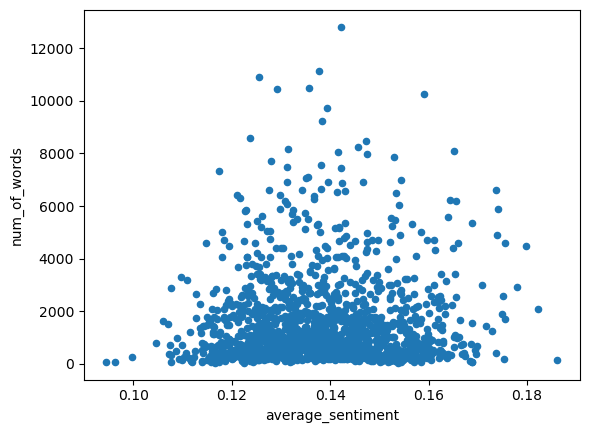

In [148]:
un.plot.scatter(x="average_sentiment", y="num_of_words")

<AxesSubplot: >

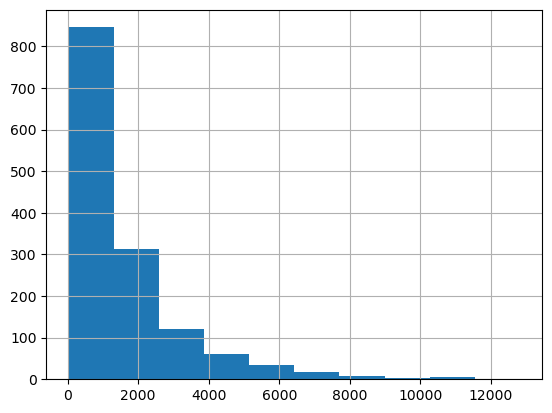

In [155]:
un['num_of_words'].hist()

In [135]:
final = unordered.sort_values(by=['average_sentiment'])

In [150]:
final

,average_sentiment
Kabul Khel,0.094532
Battle of Suriname,0.096249
Ottoman–Venetian War (1499–1503),0.099804
Invasion of Java (1811),0.104674
Second Silesian War,0.106127
...,...
Kurdish–Turkish conflict (1978–present),0.175561
1860 civil conflict in Mount Lebanon and Damascus,0.177879
Salvadoran Civil War,0.179848
Allied Democratic Forces insurgency,0.182148


In [153]:
final.tail(10)

,average_sentiment
Croatian War of Independence,0.173998
Burundian Civil War,0.174897
Algerian Civil War,0.175048
Rupununi Uprising,0.175207
Lord's Resistance Army insurgency,0.175553
Kurdish–Turkish conflict (1978–present),0.175561
1860 civil conflict in Mount Lebanon and Damascus,0.177879
Salvadoran Civil War,0.179848
Allied Democratic Forces insurgency,0.182148
Georgian Civil War,0.186124


In [137]:
biascount=0
neutcount=0
for k in list(dd.keys()):
    if abs(dd[k])<=0.25:
        neutcount +=1
    if abs(dd[k]>=0.4):
        biascount+=1

array([[<AxesSubplot: title={'center': 'average_sentiment'}>]],
      dtype=object)

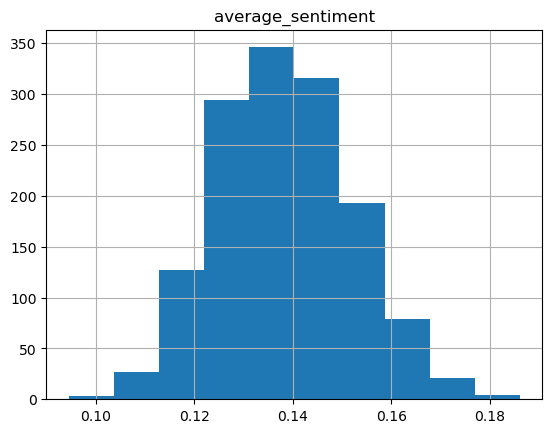

In [138]:
final.hist()

In [139]:
final.mean()

average_sentiment    0.138328
dtype: float64

In [79]:
indexxed = unordered
indexxed['article_order'] = np.arange(indexxed.shape[0])
indexxed

,average_sentiment,article_order
Narmer,0.143173,0
Hor-Aha,0.129515,1
Enmerkar,0.143320,2
Kish (Sumer),0.135692,3
Gilgamesh and Aga,0.143208,4
Sneferu,0.148728,5
Entemena,0.150104,6
Akkadian Empire,0.148608,7
Sargon of Akkad,0.156612,8
Naram-Sin of Akkad,0.159631,9


<AxesSubplot: xlabel='article_order', ylabel='average_sentiment'>

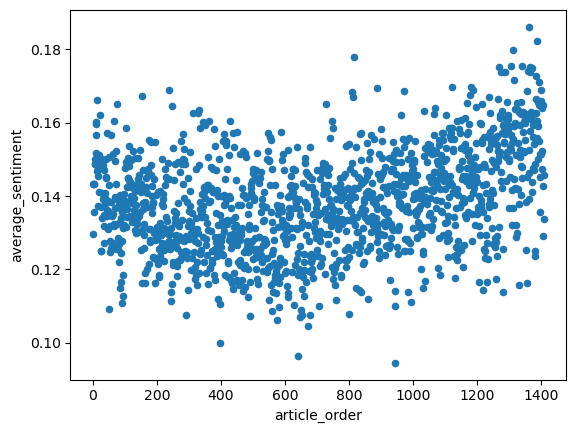

In [80]:
indexxed.plot.scatter(x="article_order", y="average_sentiment")

<AxesSubplot: xlabel='article_order', ylabel='average_sentiment'>

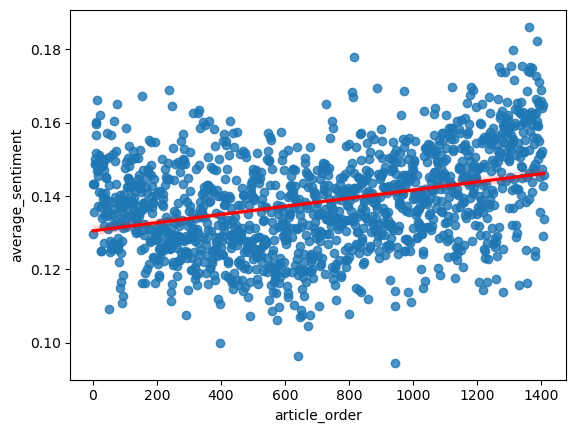

In [86]:
import seaborn as sns
sns.regplot(x=indexxed['article_order'],y=indexxed['average_sentiment'], line_kws={"color": "red"})

In [53]:
len(final.index)

1410